# Tibia Auction Market Analysis - Data Exploration

## Analysis Goals:
1. **Data Exploration** - understanding data structure and quality
2. **Price Trend Analysis** - identifying temporal patterns
3. **World Segmentation** - grouping by market characteristics
4. **Preparation for Predictive Modeling**

## Research Questions:
- Which factors most influence character prices?
- Are there differences between worlds (PvP vs PvE)?
- What does seasonality look like in the market?
- Can we predict future prices?


Libraries imports

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Database connection
import psycopg2
from sqlalchemy import create_engine, text


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy.stats import pearsonr

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully.")

Libraries imported successfully.


Connection with database

In [3]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Database connection config from environment variables
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', '5432'),
    'database': os.getenv('DB_NAME', 'auction_data'),
    'user': os.getenv('DB_USER', 'scraper'),
    'password': os.getenv('DB_PASSWORD')
}

# Create connection string
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"

# Create engine
engine = create_engine(connection_string)

print("Database connection configured.")


Database connection configured.


In [4]:
index_queries = [
    "CREATE INDEX IF NOT EXISTS idx_auctions_character_id ON auctions(character_id);",
    "CREATE INDEX IF NOT EXISTS idx_auctions_filters ON auctions(has_been_bidded, is_historical);",
    "CREATE INDEX IF NOT EXISTS idx_characters_skills_id ON characters(skills_id);",
    "CREATE INDEX IF NOT EXISTS idx_characters_world_id ON characters(world_id);"
]

for query in index_queries:
    try:
        with engine.connect() as conn:
            conn.execute(text(query)) 
            conn.commit()              
        print(f"Index created: {query}")
    except Exception as e:
        print(f"Error: {e}")


Index created: CREATE INDEX IF NOT EXISTS idx_auctions_character_id ON auctions(character_id);
Index created: CREATE INDEX IF NOT EXISTS idx_auctions_filters ON auctions(has_been_bidded, is_historical);
Index created: CREATE INDEX IF NOT EXISTS idx_characters_skills_id ON characters(skills_id);
Index created: CREATE INDEX IF NOT EXISTS idx_characters_world_id ON characters(world_id);


In [5]:
# Get all tables and their columns
schema_query = """
SELECT 
    table_name,
    column_name,
    data_type,
    is_nullable
FROM information_schema.columns 
WHERE table_schema = 'public'
ORDER BY table_name, ordinal_position;
"""

schema_df = pd.read_sql(schema_query, engine)
print("Database schema:")
print(schema_df.to_string(index=False))


Database schema:
                 table_name         column_name                   data_type is_nullable
                   auctions                  id                     integer          NO
                   auctions        character_id                     integer         YES
                   auctions         auction_end                      bigint          NO
                   auctions         current_bid                     integer          NO
                   auctions     has_been_bidded                     boolean          NO
                   auctions       is_historical                     boolean          NO
                   auctions          scraped_at timestamp without time zone         YES
     character_greater_gems                  id                     integer          NO
     character_greater_gems        character_id                     integer         YES
     character_greater_gems     gem_description           character varying          NO
     character_

In [12]:
schema_query = """
SELECT 
    a.id AS auction_id,
    a.current_bid,
    a.auction_end,
    c.id AS character_id, 
    c.vocation_id, 
    c.level, 
    c.sex,
    c.achievement_points,
    c.boss_points,
    c.charm_total,
    c.charm_expansion,
    c.prey_slot,
    c.hunting_slot,
    c.transfer,
    c.gems_greater,
    c.outfits_count,
    c.mounts_count,
    c.store_mounts_count,
    c.store_outfits_count,
    c.hirelings_count,
    s.magic, s.axe, s.sword, s.club, s.distance, s.shielding, s.fist,
    w.pvp_type,
    w.battleye,
    w.location
FROM auctions a 
JOIN characters c ON a.character_id = c.id
LEFT JOIN skills s ON c.skills_id = s.id
LEFT JOIN worlds w ON c.world_id = w.id
WHERE a.has_been_bidded = true
    AND a.is_historical = true
"""
auctions_df = pd.read_sql(schema_query, engine)

auctions_df['auction_end_dt'] = pd.to_datetime(auctions_df['auction_end'], unit='s')
auctions_df['auction_month'] = auctions_df['auction_end_dt'].dt.month
auctions_df['auction_day_of_week'] = auctions_df['auction_end_dt'].dt.dayofweek

display(auctions_df.head())
print(auctions_df.info())

,auction_id,current_bid,auction_end,character_id,vocation_id,level,sex,achievement_points,boss_points,charm_total,charm_expansion,prey_slot,hunting_slot,transfer,gems_greater,outfits_count,mounts_count,store_mounts_count,store_outfits_count,hirelings_count,magic,axe,sword,club,distance,shielding,fist,pvp_type,battleye,location,auction_end_dt,auction_month,auction_day_of_week
0,1998186,276,1762722000,1998186,3,172,True,76,20,788,False,False,False,True,0,14,2,0,0,0,79.28,16.50,13.95,12.27,19.14,34.76,12.78,Open,True,BR,2025-11-09 21:00:00,11,6
1,1949423,200,1757062800,1949423,1,82,False,18,0,140,False,False,False,True,0,13,1,0,0,0,7.66,18.64,110.82,28.87,24.28,103.75,10.74,Optional,False,NA,2025-09-05 09:00:00,9,4
2,1998092,6301,1762592400,1998092,4,492,False,211,1800,4559,False,False,False,False,0,27,8,0,1,0,116.06,20.27,19.14,13.74,12.89,34.40,13.83,Open,False,NA,2025-11-08 09:00:00,11,5
3,1997966,1020,1762592400,1997966,3,343,False,311,810,1445,False,False,False,False,0,24,14,0,0,0,92.83,12.22,19.85,17.25,19.52,38.15,14.06,Open,False,BR,2025-11-08 09:00:00,11,5
4,1925022,1500,1754348400,1925022,4,380,False,260,590,2806,False,False,False,True,0,27,7,0,0,0,94.97,12.26,14.11,13.67,20.18,35.45,13.75,Open,False,BR,2025-08-04 23:00:00,8,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815152 entries, 0 to 815151
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   auction_id           815152 non-null  int64         
 1   current_bid          815152 non-null  int64         
 2   auction_end          815152 non-null  int64         
 3   character_id         815152 non-null  int64         
 4   vocation_id          815152 non-null  int64         
 5   level                815152 non-null  int64         
 6   sex                  815152 non-null  bool          
 7   achievement_points   815152 non-null  int64         
 8   boss_points          815152 non-null  int64         
 9   charm_total          815152 non-null  int64         
 10  charm_expansion      815152 non-null  bool          
 11  prey_slot            815152 non-null  bool          
 12  hunting_slot         815152 non-null  bool          
 13  transfer      

# Skills analysis for each profession

In [13]:
vocation_skills = auctions_df.groupby('vocation_id').agg({
    'magic': 'mean',
    'distance': 'mean',
    'sword': 'mean',
    'axe': 'mean',
    'club': 'mean',
    'shielding': 'mean',
    'fist': 'mean',
    'auction_id' : 'count'
}).round(3)

vocation_skills.columns = ['avg_magic', 'avg_distance', 'avg_sword', 'avg_axe', 'avg_club', 'avg_shielding', 'avg_fist', 'count']
print("Average skills for each profession:")
display(vocation_skills)



Average skills for each profession:


,avg_magic,avg_distance,avg_sword,avg_axe,avg_club,avg_shielding,avg_fist,count
vocation_id,,,,,,,,
0,2.211,14.596,17.963,13.544,13.844,22.293,12.435,1363
1,9.284,19.063,73.920,58.528,53.432,101.059,15.553,249867
2,26.040,111.846,21.298,16.383,18.450,99.713,16.078,220784
3,85.046,15.525,14.760,12.859,13.533,33.452,13.295,149761
4,88.271,16.467,15.639,13.141,14.067,33.742,13.567,186499
5,31.797,13.888,14.048,13.514,14.002,58.141,88.724,6878


## Skills Normalization - Percentile Ranking by Vocation

Since skills have different difficulty scales across vocations, we need to normalize them to make fair comparisons.


In [55]:

skill_columns = ['magic', 'sword', 'axe', 'club', 'distance', 'shielding', 'fist']

print("Creating normalized skills (percentiles within vocation)...")

for skill in skill_columns:
    # Create percentile ranking within each vocation
    auctions_df[f'{skill}_percentile'] = auctions_df.groupby('vocation_id')[skill].rank(pct=True)
    
    # Also create z-score normalization for comparison
    auctions_df[f'{skill}_zscore'] = auctions_df.groupby('vocation_id')[skill].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0  # DODANE: zabezpieczenie przed dzieleniem przez 0
    )

print("Normalization completed!")

# Show example of normalization for sword skill
print("\nExample - Sword skill normalization:")
sample_data = auctions_df[auctions_df['vocation_id'].isin([1,2])][
    ['vocation_id', 'sword', 'sword_percentile', 'sword_zscore']
].head(10)
display(sample_data)


Creating normalized skills (percentiles within vocation)...
Normalization completed!

Example - Sword skill normalization:


,vocation_id,sword,sword_percentile,sword_zscore
1,1,110.82,0.778408,0.963246
5,2,44.15,0.994001,2.555482
7,2,13.20,0.092683,-0.905506
13,2,13.77,0.196457,-0.841766
16,2,14.90,0.425368,-0.715403
17,2,16.72,0.521949,-0.511881
22,1,38.94,0.230485,-0.913130
23,1,116.10,0.888138,1.101077
27,2,14.41,0.397631,-0.770197
28,2,21.55,0.604663,0.028234


Skill distribution comparison - Raw vs Percentile:


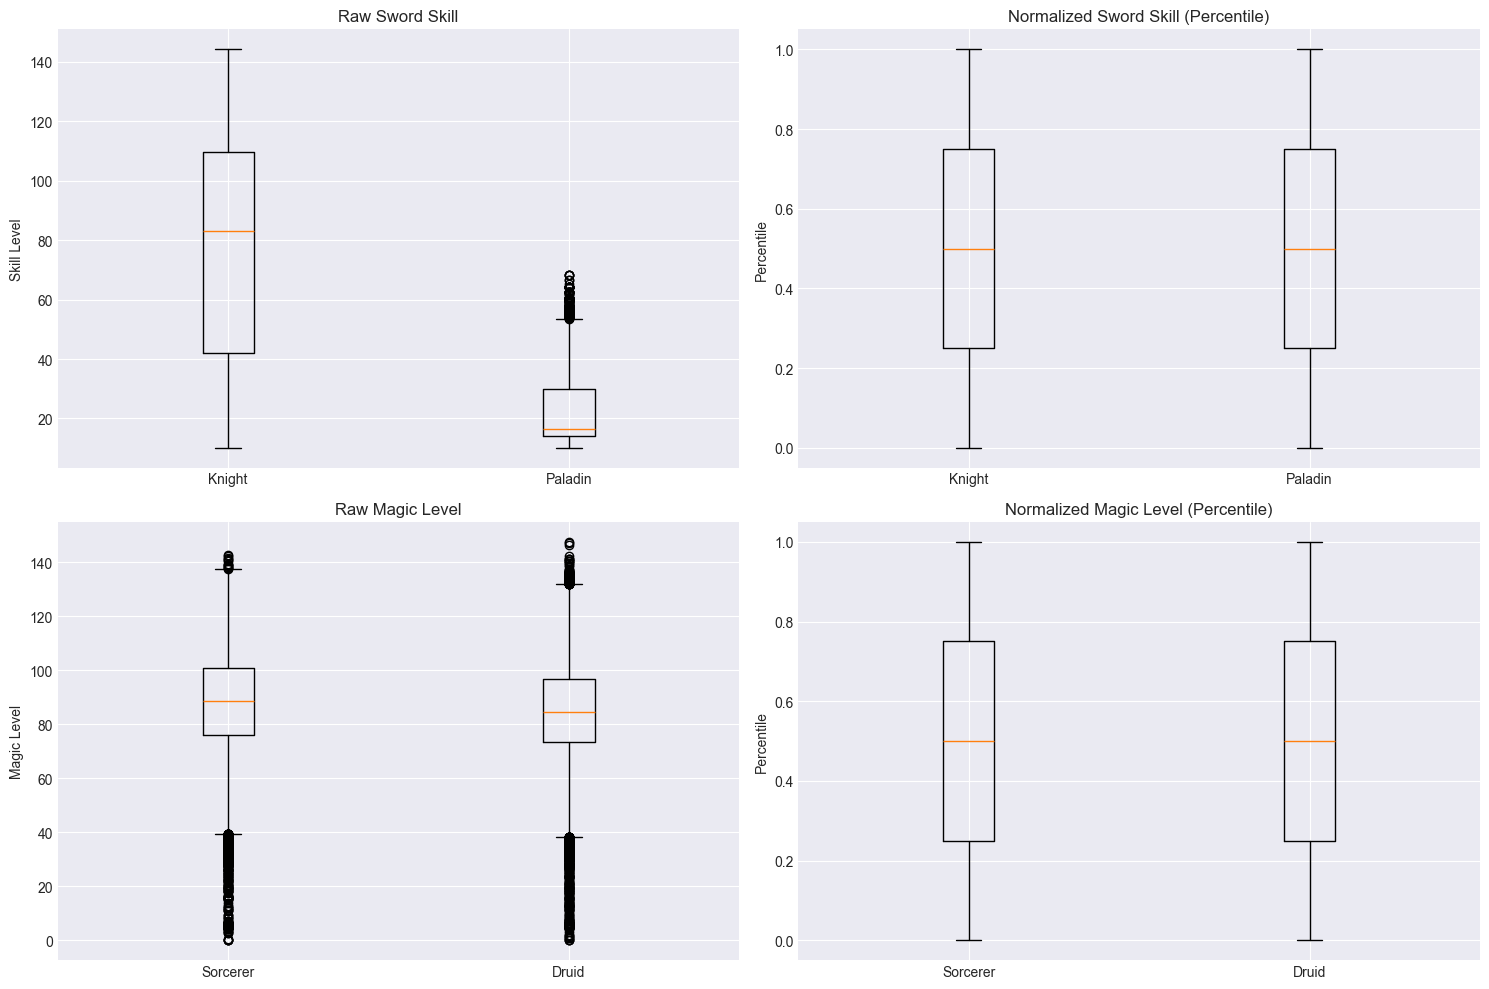

In [56]:

print("Skill distribution comparison - Raw vs Percentile:")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Filtruj dane żeby uniknąć pustych grup
knight_data = auctions_df[auctions_df['vocation_id']==1]
paladin_data = auctions_df[auctions_df['vocation_id']==2]
sorcerer_data = auctions_df[auctions_df['vocation_id']==4]
druid_data = auctions_df[auctions_df['vocation_id']==3]

# Raw sword skill by vocation
axes[0,0].boxplot([knight_data['sword'], paladin_data['sword']], 
                  labels=['Knight', 'Paladin'])
axes[0,0].set_title('Raw Sword Skill')
axes[0,0].set_ylabel('Skill Level')

# Normalized sword skill by vocation  
axes[0,1].boxplot([knight_data['sword_percentile'], paladin_data['sword_percentile']], 
                  labels=['Knight', 'Paladin'])
axes[0,1].set_title('Normalized Sword Skill (Percentile)')
axes[0,1].set_ylabel('Percentile')

# Raw magic skill
axes[1,0].boxplot([sorcerer_data['magic'], druid_data['magic']], 
                  labels=['Sorcerer', 'Druid'])
axes[1,0].set_title('Raw Magic Level')
axes[1,0].set_ylabel('Magic Level')

# Normalized magic skill
axes[1,1].boxplot([sorcerer_data['magic_percentile'], druid_data['magic_percentile']], 
                  labels=['Sorcerer', 'Druid'])
axes[1,1].set_title('Normalized Magic Level (Percentile)')
axes[1,1].set_ylabel('Percentile')

plt.tight_layout()
plt.show()


In [43]:
vocation_mapping = {
    0: 'None/Rokie',
    1: 'Knight', #high malee skills
    2: 'Paladin', #high distance and shielding
    3: 'Druid', #high magic
    4: 'Sorcerer', #high magic
    5: 'Monk' #high fist
 }

auctions_df['vocation_name'] = auctions_df['vocation_id'].map(vocation_mapping)

#tab with names of characters instead coded
vocation_skills_named = vocation_skills.copy()
vocation_skills_named.index = vocation_skills_named.index.map(vocation_mapping)
print("\n Average skills for each profession:")
display(vocation_skills_named)



 Average skills for each profession:


,avg_magic,avg_distance,avg_sword,avg_axe,avg_club,avg_shielding,avg_fist,count
vocation_id,,,,,,,,
None/Rokie,2.211,14.596,17.963,13.544,13.844,22.293,12.435,1363
Knight,9.284,19.063,73.920,58.528,53.432,101.059,15.553,249867
Paladin,26.040,111.846,21.298,16.383,18.450,99.713,16.078,220784
Druid,85.046,15.525,14.760,12.859,13.533,33.452,13.295,149761
Sorcerer,88.271,16.467,15.639,13.141,14.067,33.742,13.567,186499
Monk,31.797,13.888,14.048,13.514,14.002,58.141,88.724,6878


In [44]:
# basic dataset statistics
print("Dataset Overview:")
print(f"Total auctions: {len(auctions_df):,}")
print(f"Date range: {auctions_df['auction_end_dt'].min().strftime('%d-%m-%Y')} to {auctions_df['auction_end_dt'].max().strftime('%d-%m-%Y')}")
print(f"Price range: {auctions_df['current_bid'].min():,} - {auctions_df['current_bid'].max():,} TC")

# Price statistics
print("\nPrice Statistics:")
price_stats = auctions_df['current_bid'].describe(percentiles=[.25, .5, .75, .90, .95, .99])
display(price_stats)

# Character level statistics  
print("\nCharacter Level Statistics:")
level_stats = auctions_df['level'].describe(percentiles=[.25, .5, .75, .90, .95, .99])
display(level_stats)

# Distribution by key variables
print("\nVocation Distribution:")
print(auctions_df['vocation_name'].value_counts())

print("\nPvP Type Distribution:")
print(auctions_df['pvp_type'].value_counts())

print("\nLocation Distribution:")
print(auctions_df['location'].value_counts())


Dataset Overview:
Total auctions: 815,152
Date range: 27-11-2021 to 12-11-2025
Price range: 57 - 1,100,000 TC

Price Statistics:


count    8.151520e+05
mean     3.349994e+03
std      8.985060e+03
min      5.700000e+01
25%      2.860000e+02
50%      1.000000e+03
75%      3.000000e+03
90%      7.401000e+03
95%      1.400100e+04
99%      3.965100e+04
max      1.100000e+06
Name: current_bid, dtype: float64


Character Level Statistics:


count    815152.000000
mean        295.119062
std         225.064253
min           8.000000
25%         119.000000
50%         255.000000
75%         416.000000
90%         603.000000
95%         730.000000
99%        1005.000000
max        2610.000000
Name: level, dtype: float64


Vocation Distribution:
vocation_name
Knight        249867
Paladin       220784
Sorcerer      186499
Druid         149761
Monk            6878
None/Rokie      1363
Name: count, dtype: int64

PvP Type Distribution:
pvp_type
Open              385891
Optional          327459
Retro Open         66556
Retro Hardcore     31603
Hardcore            3643
Name: count, dtype: int64

Location Distribution:
location
BR     376790
EU     237615
NA     199289
OCE      1458
Name: count, dtype: int64


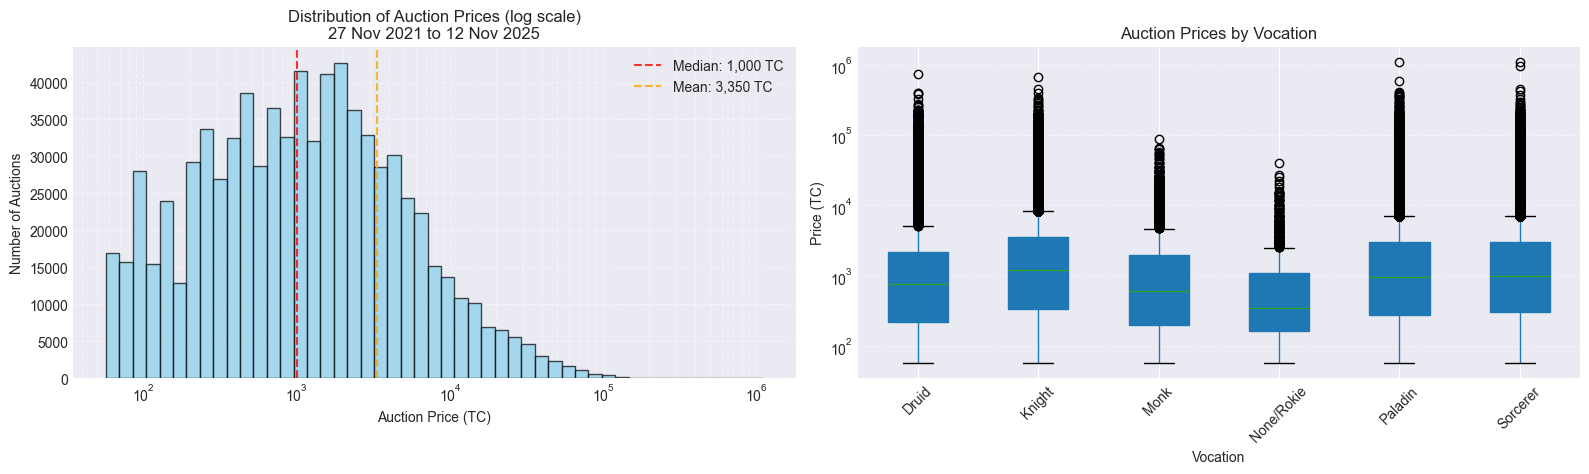

Price Statistics:
Total auctions: 815,152
Price range: 57 - 1,100,000 TC
Median price: 1,000 TC
Mean price: 3,350 TC
95th percentile: 14,001 TC


In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Histogram with log-scaled X axis
prices = auctions_df['current_bid'].dropna()
bins = np.logspace(np.log10(prices.min()), np.log10(prices.max()), 50)
ax1.hist(prices, bins=bins, edgecolor='black', alpha=0.7, color='skyblue')
ax1.set_xscale('log')
ax1.set_xlabel('Auction Price (TC)')
ax1.set_ylabel('Number of Auctions')
ax1.set_title('Distribution of Auction Prices (log scale)')
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Add date range to title 
date_min = auctions_df['auction_end_dt'].min().strftime('%d %b %Y')  
date_max = auctions_df['auction_end_dt'].max().strftime('%d %b %Y')
ax1.set_title(f'Distribution of Auction Prices (log scale)\n{date_min} to {date_max}')

ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Add statistics text
median_price = prices.median()
mean_price = prices.mean()
ax1.axvline(median_price, color='red', linestyle='--', alpha=0.8, label=f'Median: {median_price:,.0f} TC')
ax1.axvline(mean_price, color='orange', linestyle='--', alpha=0.8, label=f'Mean: {mean_price:,.0f} TC')
ax1.legend()

# Boxplot by vocation
auctions_df.boxplot(column='current_bid', 
                   by='vocation_name', 
                   ax=ax2,
                   showfliers=True,
                   patch_artist=True)
ax2.set_title('Auction Prices by Vocation')
ax2.set_xlabel('Vocation')
ax2.set_ylabel('Price (TC)')
ax2.set_yscale('log')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, axis='y', linestyle='--', alpha=0.5)

# Remove automatic pandas title
plt.suptitle('')
plt.tight_layout()
plt.show()

# Print some insights
print(f"Price Statistics:")
print(f"Total auctions: {len(prices):,}")
print(f"Price range: {prices.min():,} - {prices.max():,} TC")
print(f"Median price: {median_price:,.0f} TC")
print(f"Mean price: {mean_price:,.0f} TC")
print(f"95th percentile: {prices.quantile(0.95):,.0f} TC")


# World Distribution

In [57]:
print("=== WORLD DISTRIBUTION ANALYSIS ===\n")

# 1. Auctions by Region
print("1. Auctions by Region:")
region_counts = auctions_df['location'].value_counts()
print(region_counts)
print(f"\nPercentage distribution:")
region_pct = (region_counts / len(auctions_df) * 100).round(2)
print(region_pct)

# 2. Auctions by PvP Type
print("\n2. Auctions by PvP Type:")
pvp_counts = auctions_df['pvp_type'].value_counts()
print(pvp_counts)
print(f"\nPercentage distribution:")
pvp_pct = (pvp_counts / len(auctions_df) * 100).round(2)
print(pvp_pct)

# 3. BattlEye Impact
print("\n3. BattlEye Impact:")
battleye_counts = auctions_df['battleye'].value_counts()
print(f"BattlEye enabled: {battleye_counts[True]:,}")
print(f"BattlEye disabled: {battleye_counts[False]:,}")
battleye_pct = (battleye_counts / len(auctions_df) * 100).round(2)
print(f"\nPercentage with BattlEye: {battleye_pct[True]:.2f}%")




=== WORLD DISTRIBUTION ANALYSIS ===

1. Auctions by Region:
location
BR     376790
EU     237615
NA     199289
OCE      1458
Name: count, dtype: int64

Percentage distribution:
location
BR     46.22
EU     29.15
NA     24.45
OCE     0.18
Name: count, dtype: float64

2. Auctions by PvP Type:
pvp_type
Open              385891
Optional          327459
Retro Open         66556
Retro Hardcore     31603
Hardcore            3643
Name: count, dtype: int64

Percentage distribution:
pvp_type
Open              47.34
Optional          40.17
Retro Open         8.16
Retro Hardcore     3.88
Hardcore           0.45
Name: count, dtype: float64

3. BattlEye Impact:
BattlEye enabled: 351,334
BattlEye disabled: 463,818

Percentage with BattlEye: 43.10%


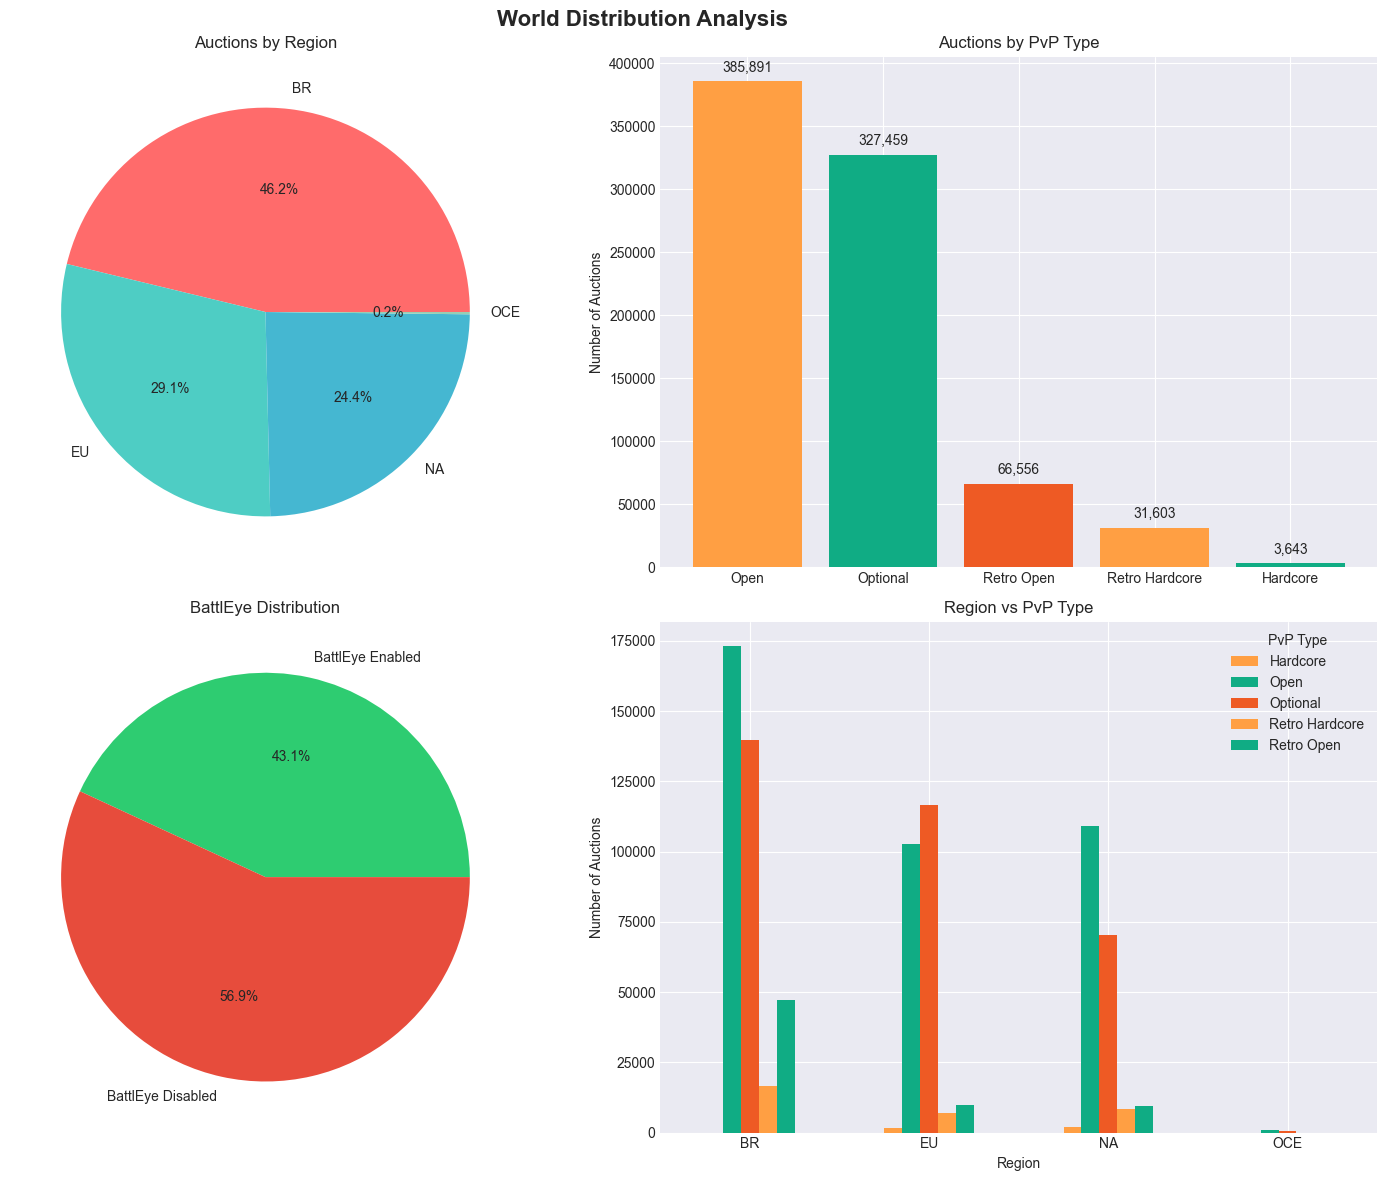

In [58]:
# Visualizations for World Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('World Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Region Distribution
axes[0, 0].pie(region_counts.values, labels=region_counts.index, autopct='%1.1f%%', 
               colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0, 0].set_title('Auctions by Region')

# 2. PvP Type Distribution
axes[0, 1].bar(pvp_counts.index, pvp_counts.values, color=['#FF9F43', '#10AC84', '#EE5A24'])
axes[0, 1].set_title('Auctions by PvP Type')
axes[0, 1].set_ylabel('Number of Auctions')
for i, v in enumerate(pvp_counts.values):
    axes[0, 1].text(i, v + 5000, f'{v:,}', ha='center', va='bottom')

# 3. BattlEye Distribution
battleye_labels = ['BattlEye Enabled', 'BattlEye Disabled']
battleye_values = [battleye_counts[True], battleye_counts[False]]
axes[1, 0].pie(battleye_values, labels=battleye_labels, autopct='%1.1f%%', 
               colors=['#2ECC71', '#E74C3C'])
axes[1, 0].set_title('BattlEye Distribution')

# 4. Cross-analysis: Region vs PvP Type
region_pvp = pd.crosstab(auctions_df['location'], auctions_df['pvp_type'])
region_pvp.plot(kind='bar', ax=axes[1, 1], color=['#FF9F43', '#10AC84', '#EE5A24'])
axes[1, 1].set_title('Region vs PvP Type')
axes[1, 1].set_xlabel('Region')
axes[1, 1].set_ylabel('Number of Auctions')
axes[1, 1].legend(title='PvP Type')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [59]:
# Detailed Cross-Analysis
print("\n=== DETAILED CROSS-ANALYSIS ===\n")

# Region vs PvP Type crosstab
print("Region vs PvP Type:")
region_pvp_table = pd.crosstab(auctions_df['location'], auctions_df['pvp_type'], margins=True)
print(region_pvp_table)

print("\nPercentage within each region:")
region_pvp_pct = pd.crosstab(auctions_df['location'], auctions_df['pvp_type'], normalize='index') * 100
print(region_pvp_pct.round(2))

# Region vs BattlEye
print("\n\nRegion vs BattlEye:")
region_battleye = pd.crosstab(auctions_df['location'], auctions_df['battleye'], margins=True)
print(region_battleye)

print("\nPercentage with BattlEye by region:")
region_battleye_pct = pd.crosstab(auctions_df['location'], auctions_df['battleye'], normalize='index') * 100
print(region_battleye_pct.round(2))

# PvP Type vs BattlEye
print("\n\nPvP Type vs BattlEye:")
pvp_battleye = pd.crosstab(auctions_df['pvp_type'], auctions_df['battleye'], margins=True)
print(pvp_battleye)

print("\nPercentage with BattlEye by PvP type:")
pvp_battleye_pct = pd.crosstab(auctions_df['pvp_type'], auctions_df['battleye'], normalize='index') * 100
print(pvp_battleye_pct.round(2))



=== DETAILED CROSS-ANALYSIS ===

Region vs PvP Type:
pvp_type  Hardcore    Open  Optional  Retro Hardcore  Retro Open     All
location                                                                
BR               0  173145    139866           16533       47246  376790
EU            1563  102737    116620            6827        9868  237615
NA            2080  109114     70410            8243        9442  199289
OCE              0     895       563               0           0    1458
All           3643  385891    327459           31603       66556  815152

Percentage within each region:
pvp_type  Hardcore   Open  Optional  Retro Hardcore  Retro Open
location                                                       
BR            0.00  45.95     37.12            4.39       12.54
EU            0.66  43.24     49.08            2.87        4.15
NA            1.04  54.75     35.33            4.14        4.74
OCE           0.00  61.39     38.61            0.00        0.00


Region vs BattlEy